In [1]:
!date

Wed Aug 23 13:49:59 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
%%time
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns
from IPython import display


CPU times: user 1.26 s, sys: 287 ms, total: 1.55 s
Wall time: 6.2 s


In [4]:
%%time
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 10.7 µs


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [8]:
dataset_path_bg = './Data/pytorch-data/xl_121_15_action_data_bg'
dataset_path_seg = './Data/pytorch-data/xl_121_15_action_data_seg'

cats = os.listdir(os.path.join(dataset_path_bg,'train'))
cats.sort()
cats = np.array(cats)

n_cats = len(cats)

train_images = []
train_cats = []
train_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'train',cat)) if f.endswith('.jpg')]
    temp.sort()
    train_images.append(temp)
    train_cats.append( list(np.repeat(cat,len(temp))) )
    train_cats_idx.append( list(np.repeat(idx,len(temp))) )

val_images = []
val_cats = []
val_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'val',cat)) if f.endswith('.jpg')]
    temp.sort()
    val_images.append(temp)
    val_cats.append( list(np.repeat(cat,len(temp))) )
    val_cats_idx.append( list(np.repeat(idx,len(temp))) )

#val_images_n = np.array([len(val) for val in train_images])
val_images_n = np.array([len(val) for val in val_images])

In [9]:
test_images = []
test_cats = []
test_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'test',cat)) if f.endswith('.jpg')]
    temp.sort()
    test_images.append(temp)
    test_cats.append( list(np.repeat(cat,len(temp))) )
    test_cats_idx.append( list(np.repeat(idx,len(temp))) )

#val_images_n = np.array([len(val) for val in train_images])
test_images_n = np.array([len(val) for val in test_images])

In [10]:
# CHECK that train images have BG and SEG versions
train_vec_im = np.hstack(train_images)
train_vec_cat = np.hstack(train_cats)
train_vec_n = len(train_vec_im)
train_vec_cat_idx = np.hstack(train_cats_idx)

#check_vec_train = [os.path.exists(os.path.join(dataset_path_seg,'train',train_vec_cat[i],train_vec_im[i])) for i in tqdm(range(len(train_vec_im)))]
#assert all(check_vec_train), 'mistatch in TRAIN images'

In [11]:
# CHECK that val images have BG and SEG versions
val_vec_im = np.hstack(val_images)
val_vec_cat = np.hstack(val_cats)
val_vec_n = len(val_vec_im)
val_vec_cat_idx = np.hstack(val_cats_idx)

#check_vec_val = [os.path.exists(os.path.join(dataset_path_seg,'val',val_vec_cat[i],val_vec_im[i])) for i in tqdm(range(len(val_vec_im)))]
#assert all(check_vec_val), 'mistatch in VAL images'

In [12]:
assert train_vec_n==95056, 'check failed'

In [13]:
training_data_orig = np.load('./Data/pytorch-data/DomainNet-frames-train-95056-orig.npy')

In [14]:
val_data_orig = np.load('./Data/pytorch-data/DomainNet-frames-val-6936-orig.npy')

In [15]:
def divide_chunks(l, n):
    # Yield successive n-sized
    # chunks from l.
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

val_chunks = list(divide_chunks(np.random.permutation(np.arange(val_vec_n)), 32))

In [18]:
batch_size=32

def get_batch_from_loaded(batch_size):
    cat_idx = np.random.randint(low=0,high=n_cats,size=batch_size) # Select random categories (idx)
    im_idx = np.array([np.random.choice(np.nonzero(train_vec_cat_idx==c)[0]) for c in cat_idx]) # Select random images
    batch_orig = training_data_orig[im_idx,:,:,:] # 
    return cat_idx,batch_orig

In [19]:
def dashboard():

    #plt.close()
    
    nrows=2
    ncols=2
    c = 0
    plt.figure(figsize=(10,10))

    display.clear_output(wait=True);
    display.display(plt.gcf());
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_train_orig)
    plt.title('loss_train_orig')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_train_orig)
    plt.title('acc_train_orig')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_val_orig)
    plt.title('loss_val_orig')
    #plt.legend(['BG','SEG'])
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_val_orig)
    plt.title('acc_val_orig')
    
    t = str(now()-t00).split('.')[0]
    plt.suptitle(f'Epoch {epoch} elapsed T: {t}')
    
    plt.tight_layout()
    sys.stdout.flush()

In [21]:
batch_lbls,batch_orig = get_batch_from_loaded(batch_size=32)

Text(0.5, 0.96, 'BG')

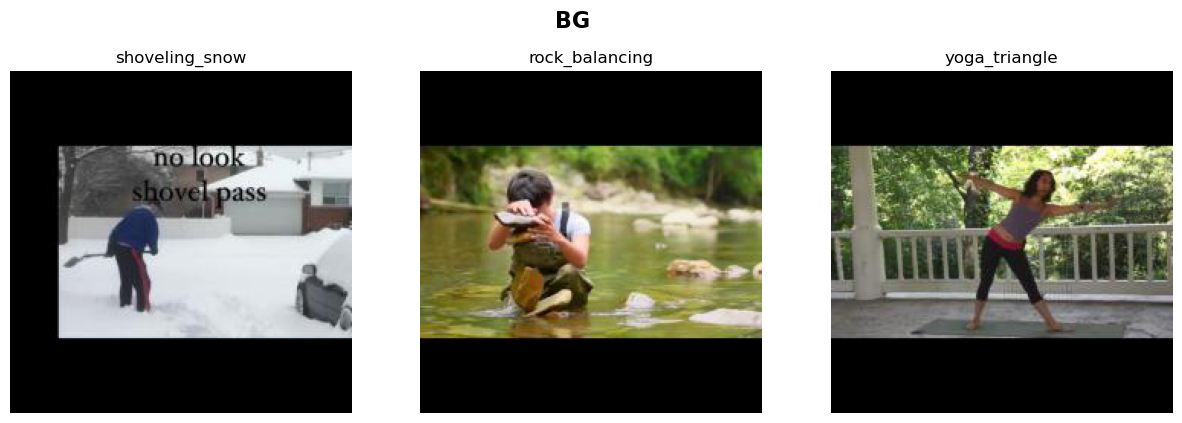

In [22]:
############ BG 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(batch_orig[0,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[0]])
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(batch_orig[1,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[1]])
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(batch_orig[2,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[2]])
plt.axis('off')
plt.suptitle('BG',fontsize=16,fontweight='bold',y=.96)

In [24]:
staticNet = resnet50()
staticNet.fc = nn.Linear(staticNet.fc.in_features,n_cats)

staticNet.half();
staticNet = staticNet.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(staticNet.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [28]:
save_dir = './Data/pytorch-data/weights/Staticnet-1'
safe_mkdir(save_dir)

In [29]:
loss_train_orig = []
acc_train_orig = []
loss_val_orig = []
acc_val_orig = []

In [ ]:
t00 = now()
for epoch in tqdm( range(100) ):
    
    temp_orig_loss = 0
    
    staticNet.train()
    for b in range(500):
    
        optimizer.zero_grad();

        batch_lbls,batch_orig = get_batch_from_loaded(batch_size=32) # NEW FASTER WAY! 0.o
        
        batch_lbls = torch.from_numpy(batch_lbls).long()
        batch_orig = torch.from_numpy(batch_orig).half()
        
        
        batch_lbls = batch_lbls.cuda()
        batch_orig = batch_orig.cuda()
        
        outputs= staticNet(batch_orig)

        
        loss = criterion(outputs, batch_lbls)
        temp_orig_loss+=loss.data.item() # Collect BATCH loss BG
    
        loss.backward()
        optimizer.step()

    # Collect data end of each epoch
    loss_train_orig.append( temp_orig_loss/b )
  
    acc_train_orig.append( (outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
  
    ### VALIDATION DATA
    staticNet.eval()

    temp_acc_val_orig = 0
    temp_orig_loss = 0
    for v,val_chunk in enumerate(val_chunks):

        # load as numpy
        batch_lbls = val_vec_cat_idx[val_chunk]
        batch_orig = val_data_orig[val_chunk,:,:,:]
       

        # convert to torch
        batch_lbls = torch.from_numpy(batch_lbls).long()
        batch_orig = torch.from_numpy(batch_orig).half()
        

        # pass to cuda
        batch_lbls = batch_lbls.cuda()
        batch_orig = batch_orig.cuda()
       

        # pass to network
       
        outputs = staticNet(batch_orig)
        
        loss = criterion(outputs, batch_lbls)
        temp_orig_loss+=loss.data.item() # Collect BATCH loss BG

        temp_acc_val_orig+=(outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean()
    
    loss_val_orig.append( temp_orig_loss/v )
 
    acc_val_orig.append( temp_acc_val_orig/v )

In [ ]:
dashboard()

In [ ]:
torch.save(staticNet.state_dict(), os.path.join(save_dir,'weights'))
np.save(os.path.join(save_dir,'loss_train_orig.npy'),loss_train_orig) 
np.save(os.path.join(save_dir,'loss_val_orig.npy'),loss_val_orig) 
np.save(os.path.join(save_dir,'acc_train_orig.npy'),acc_train_orig) 
np.save(os.path.join(save_dir,'acc_val_orig.npy'),acc_val_orig) 

In [31]:
staticNet.load_state_dict(torch.load(os.path.join(save_dir,'weights')));
loss_train_orig = np.load(os.path.join(save_dir,'loss_train_orig.npy'))
loss_val_orig = np.load(os.path.join(save_dir,'loss_val_orig.npy'))
acc_train_orig = np.load(os.path.join(save_dir,'acc_train_orig.npy'))
acc_val_orig = np.load(os.path.join(save_dir,'acc_val_orig.npy'))

In [33]:
def test_trained_staticNet(data_orig,lbls):
    
    staticNet.eval()
    n = data_orig.shape[0]
    chunks = list(divide_chunks(np.arange(n), 32))
    chunk = chunks[0]
    
    batch_lbls = lbls[chunk]
    batch_orig = data_orig[chunk,:,:,:]
   
    
    # convert to torch
    batch_lbls = torch.from_numpy(batch_lbls).long()
    batch_orig = torch.from_numpy(batch_orig).half()
   
    
    # pass to cuda
    batch_lbls = batch_lbls.cuda()
    batch_orig = batch_orig.cuda()
    
    # pass to network
    outputs = staticNet(batch_orig)
    
    outputs = outputs.detach().cpu().numpy()
   
    for i in tqdm( range(1,len(chunks)) ):
        chunk = chunks[i]
        
        batch_lbls = lbls[chunk]
        batch_orig = data_orig[chunk,:,:,:]
        #batch_seg = data_seg[chunk,:,:,:]
        
        # convert to torch
        batch_lbls = torch.from_numpy(batch_lbls).long()
        batch_orig = torch.from_numpy(batch_orig).half()
        #batch_seg = torch.from_numpy(batch_seg).half()
        
        # pass to cuda
        batch_lbls = batch_lbls.cuda()
        batch_orig = batch_orig.cuda()
        
        # pass to network
        chunk_outputs = staticNet(batch_orig)
    
        outputs = np.vstack((outputs,chunk_outputs.detach().cpu().numpy()))
        
    return outputs

In [34]:
del training_data_orig

In [35]:
del val_data_orig

In [36]:
test_data_orig = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-orig.npy')
test_data_bg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-bg.npy')
test_data_seg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-seg.npy')

In [37]:
print(test_data_orig.shape)
print(test_data_bg.shape)
print(test_data_seg.shape)

(7697, 3, 224, 224)
(7697, 3, 224, 224)
(7697, 3, 224, 224)


In [38]:
test_lbls = np.hstack(test_cats_idx)
test_lbls.shape

(7697,)

In [39]:
outputs_orig = test_trained_staticNet(test_data_orig,test_lbls)

100%|█████████████████████████████████████████| 240/240 [00:04<00:00, 54.85it/s]


In [40]:
outputs_bg = test_trained_staticNet(test_data_bg,test_lbls)

100%|█████████████████████████████████████████| 240/240 [00:04<00:00, 58.29it/s]


In [41]:
outputs_seg = test_trained_staticNet(test_data_seg,test_lbls)

100%|█████████████████████████████████████████| 240/240 [00:04<00:00, 58.75it/s]


In [46]:
acc_top1_orig = (outputs_orig.argmax(axis=1)==test_lbls).mean()
acc_top1_bg = (outputs_bg.argmax(axis=1)==test_lbls).mean()
acc_top1_seg = (outputs_seg.argmax(axis=1)==test_lbls).mean()

orig_acc_top5 = np.array([test_lbls[i] in list(np.argsort(outputs_orig[i,:])[-5::]) for i in range(len(test_lbls))]).mean()
bg_acc_top5 = np.array([test_lbls[i] in list(np.argsort(outputs_bg[i,:])[-5::]) for i in range(len(test_lbls))]).mean()
seg_acc_top5 = np.array([test_lbls[i] in list(np.argsort(outputs_seg[i,:])[-5::]) for i in range(len(test_lbls))]).mean()

Text(0.5, 1.0, 'Staticnet: Top5 acc')

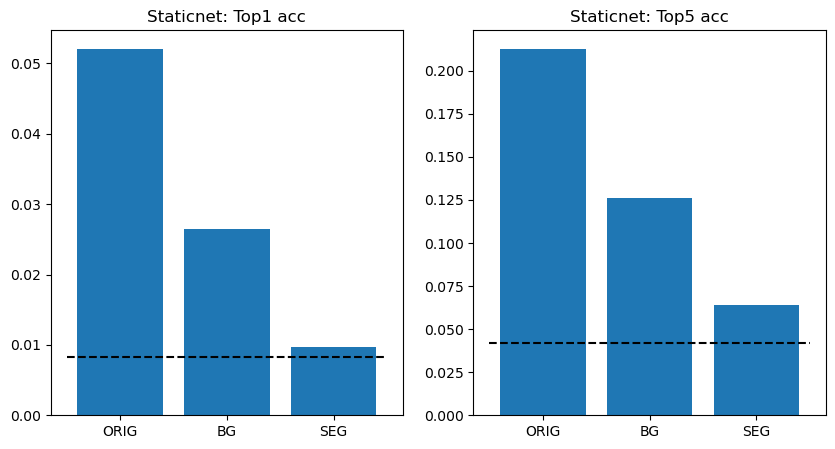

In [47]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

xs = [0,1,2]
ys = [acc_top1_orig,acc_top1_bg,acc_top1_seg];
plt.bar(xs,ys);
plt.xticks(xs,labels=['ORIG','BG','SEG']);
plt.plot([-.5,2.5],[1/121,1/121],'k--')
plt.title('Staticnet: Top1 acc')

plt.subplot(1,2,2)

xs = [0,1,2]
ys = [orig_acc_top5,bg_acc_top5,seg_acc_top5]
plt.bar(xs,ys);
plt.xticks(xs,labels=['ORIG','BG','SEG']);
plt.plot([-.5,2.5],[.042,.042],'k--')
plt.title('Staticnet: Top5 acc')

In [51]:
np.savez_compressed(os.path.join(save_dir,'test-outputs.npz'),outputs_orig=outputs_orig,outputs_bg=outputs_bg,outputs_seg=outputs_seg)

In [54]:
list(np.load(os.path.join(save_dir,'test-outputs.npz')).keys())

['outputs_orig', 'outputs_bg', 'outputs_seg']